In [6]:
import asyncio
from bs4 import BeautifulSoup
from playwright.async_api import async_playwright
import pandas as pd
from os import path
import os
import json
import numpy as np
from tqdm import tqdm
import time
from datetime import date
import glob
import re
from decimal import Decimal
import plotly.express as px
pd.set_option('display.max_columns', None)

path =r'/Users/juan.verdeguer/Desktop/python/secrets/secrets.json' 

secrets=open(path)
secrets=json.load(secrets)

In [7]:
import psycopg2
import psycopg2.extensions

psycopg2.extensions.register_type(psycopg2.extensions.UNICODE)
psycopg2.extensions.register_type(psycopg2.extensions.UNICODEARRAY)
psycopg2.extensions.register_type(psycopg2.extensions.new_type((705,), 'UNKNOWN', psycopg2.extensions.UNICODE))


def connect(**kwargs):
    conn = psycopg2.connect(**kwargs)
    conn.set_session(autocommit=True)
    conn.set_client_encoding('UNICODE')
    return conn
def execute(conn, sql):
    cur = conn.cursor() 
    cur.execute(sql)
    cur.close()
def fetchall(conn, sql):
    cur = conn.cursor()
    cur.execute(sql)
    res = cur.fetchall()
    column_names=cur.description
    cur.close()
    return res,column_names


# try:
conn=connect(host="localhost",
                          dbname="core",
                          user=secrets['db_user'],
                          password=secrets['db_password'])




In [8]:
query="""






WITH detailed AS (

SELECT s.shipment_id,
quote_id,
company_id,
q.created_at,
s.fulfilment_strategy,
price,
transport_base,
transport_locationpair ,
transport_seasonal ,
cargo_type,
cargo_subtype,
truck_id,
CASE WHEN pickup_country IS NOT NULL AND pickup_postcode IS NOT NULL THEN pickup_country||' '||pickup_postcode ELSE pickup_location end pick_up_address,
CASE WHEN drop_off_country IS NOT NULL AND drop_off_postcode IS NOT NULL THEN drop_off_country||' '||drop_off_postcode   ELSE drop_off_location end drop_off_address
FROM analytics.fct_quote q
LEFT JOIN analytics.dim_shipment s 
ON q.shipment_id =s.shipment_id 

WHERE q.created_at BETWEEN '2023-05-08'  AND '2023-05-14' --created_at BETWEEN current_date - INTERVAL '2 weeks'  AND current_date - INTERVAL '0 weeks'
AND (q.fulfilment_strategy='fullTruck' OR q.fulfilment_strategy='bulk')
--AND QUOTE_id=373868
AND q.distance>0
--AND quote_id IN ('374192','374191')
AND q.flag_created_by_is_impersonated IS null
ORDER BY q.created_at DESC)

SELECT

shipment_id,
quote_id,
d.created_at,
fulfilment_strategy,
price,
transport_base,
transport_locationpair,
transport_seasonal,
pick_up_address,
drop_off_address,
co."name", 
--category_name,
--"type", 
--cargo_subtype,
CASE WHEN shipment_id IS NOT NULL THEN 1 ELSE 0 END flag_conversion,
CASE WHEN category_name='sprinter' AND "type" ='plane' THEN 'Tarp Sprinter'
WHEN (category_name='sevenFiveTons'OR  REPLACE(cargo_subtype,'"','')='sevenFiveTons') THEN 'Truck 7.5t'
WHEN (category_name='twelveTons' OR  REPLACE(cargo_subtype,'"','')='twelveTons')  THEN 'Truck 12t'
WHEN (category_name='fortyTons'  OR  REPLACE(cargo_subtype,'"','')='fortyTons') THEN 'Semitrailer 40t'
ELSE REPLACE(cargo_subtype,'"','') END truck_type 
FROM detailed d
LEFT JOIN analytics.dim_truck t 
ON d.truck_id=t.truck_id 
LEFT JOIN analytics.dim_company co ON
d.company_id=co.company_id






""" 
cr, column_names =fetchall(conn, query)

column_names_clean=[]
column_names_clean=[elem[0] for elem in column_names] # retrieve the first element of every element in the tuple
print(column_names_clean)


df = pd.DataFrame(cr, columns=column_names_clean)

['shipment_id', 'quote_id', 'created_at', 'fulfilment_strategy', 'price', 'transport_base', 'transport_locationpair', 'transport_seasonal', 'pick_up_address', 'drop_off_address', 'name', 'flag_conversion', 'truck_type']


In [9]:
df

,shipment_id,quote_id,created_at,fulfilment_strategy,price,transport_base,transport_locationpair,transport_seasonal,pick_up_address,drop_off_address,name,flag_conversion,truck_type
0,NaN,374808,2023-05-12 16:22:35+00:00,None,653.0000000000000000,611.5800000000000000,-159.0100000000000000,200.0000000000000000,DE 96317,BE 4460,None,0,None
1,335182.0,374807,2023-05-12 14:53:41+00:00,fullTruck,415.0000000000000000,334.8000000000000000,46.8700000000000000,33.4800000000000000,BE 2830,FR 57430,Milliken Europe bv.,1,Tarp Sprinter
2,335170.0,374805,2023-05-12 14:51:10+00:00,fullTruck,835.0000000000000000,802.4400000000000000,-48.1400000000000000,80.2400000000000000,BE 8830,DE 63741,Rainer Bartsch GmbHInternationale Spedition,1,Semitrailer 40t
3,NaN,374804,2023-05-12 14:51:09+00:00,None,835.0000000000000000,802.4400000000000000,-48.1400000000000000,80.2400000000000000,BE 8830,DE 63741,None,0,Semitrailer 40t
4,335154.0,374803,2023-05-12 14:24:23+00:00,fullTruck,481.0000000000000000,453.7400000000000000,-18.1400000000000000,45.3700000000000000,FR 08430,BE 2800,TRANSALLIANCE EUROPE DUDELANGE,1,Semitrailer 40t
...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,NaN,374201,2023-05-08 06:52:59+00:00,None,760.0000000000000000,649.8100000000000000,45.4800000000000000,64.9800000000000000,DE 48346,DE 66663,None,0,Semitrailer 40t
422,333908.0,374200,2023-05-08 06:31:46+00:00,fullTruck,757.1500000000000000,594.5600000000000000,83.2300000000000000,59.4600000000000000,BE 3600,FR 57740,KUEHNE+NAGEL Sàrl,1,Semitrailer 40t
423,NaN,374199,2023-05-08 06:06:56+00:00,None,851.0000000000000000,693.4400000000000000,27.7300000000000000,69.3400000000000000,DE 81925,DE 10115,None,0,Truck 7.5t
424,NaN,374198,2023-05-08 06:06:28+00:00,None,791.0000000000000000,693.4400000000000000,27.7300000000000000,69.3400000000000000,"Lohengrinstraße 31, 81925 München, DE","Torstraße 205, 10115 Berlin, DE",None,0,Truck 7.5t


In [7]:
## Copy paste in terminal "playwright codegen --target python -o cargoboard.ipynb https://www.linkedin.de/"

In [8]:
### Fix unique pick_up and drop_off combos

In [334]:
# Rerun when scraper fails
quotes_not_found = []
for value in df['quote_id']:

    directory_path =  r'/Users/juan.verdeguer/Desktop/python/webscraper/pricing/20230515/' 
    file_name_pattern = f'{value}.csv'
   # print(file_name_pattern)
    # Construct the search pattern
    search_pattern = directory_path  + file_name_pattern
   # print('search pattern: '+str(search_pattern))
   
    matching_files = glob.glob(search_pattern, recursive=True)
  #  print(search_pattern)
   # print('matching files: '+str(matching_files))
# Iterate over all files in the search pattern
   # for file_path in glob.iglob(search_pattern, recursive=True):
    #print(search_pattern)
        # Check if the file path is not in the list of matching files
    if search_pattern not in matching_files:
            quotes_not_found.append(file_name_pattern.replace(".csv",'').strip())


In [336]:
cleaned_df=df[df['quote_id'].astype(str).isin(quotes_not_found)].reset_index(drop=True)
cleaned_df


,shipment_id,quote_id,created_at,fulfilment_strategy,price,transport_base,transport_locationpair,transport_seasonal,pick_up_address,drop_off_address,name,truck_type
0,334148.0,374328,2023-05-09 07:02:59+00:00,fullTruck,988.0000000000000000,866.3600000000000000,34.6500000000000000,86.6400000000000000,DE 66129,DE 14974,Home24 Outlet GmbH,Truck 12t
1,NaN,374326,2023-05-09 06:46:32+00:00,None,516.0000000000000000,465.3100000000000000,4.6500000000000000,46.5300000000000000,DE 35415,DE 45883,None,Semitrailer 40t
2,NaN,374323,2023-05-09 06:13:17+00:00,None,1245.0000000000000000,819.8000000000000000,-131.1600000000000000,200.0000000000000000,DE 23556,DE 91054,None,
3,334113.0,374322,2023-05-09 05:57:45+00:00,fullTruck,1062.0000000000000000,1206.7700000000000000,-265.4800000000000000,120.6800000000000000,DE 98701,IT 40010,Lightweight containers B.V.,Semitrailer 40t
4,NaN,374321,2023-05-09 04:44:23+00:00,None,658.0000000000000000,587.7800000000000000,-129.3100000000000000,200.0000000000000000,37627 Deensen,IT 37141,None,
...,...,...,...,...,...,...,...,...,...,...,...,...
89,NaN,374201,2023-05-08 06:52:59+00:00,None,760.0000000000000000,649.8100000000000000,45.4800000000000000,64.9800000000000000,DE 48346,DE 66663,None,Semitrailer 40t
90,333908.0,374200,2023-05-08 06:31:46+00:00,fullTruck,757.1500000000000000,594.5600000000000000,83.2300000000000000,59.4600000000000000,BE 3600,FR 57740,KUEHNE+NAGEL Sàrl,Semitrailer 40t
91,NaN,374199,2023-05-08 06:06:56+00:00,None,851.0000000000000000,693.4400000000000000,27.7300000000000000,69.3400000000000000,DE 81925,DE 10115,None,sevenFiveTons
92,NaN,374198,2023-05-08 06:06:28+00:00,None,791.0000000000000000,693.4400000000000000,27.7300000000000000,69.3400000000000000,"Lohengrinstraße 31, 81925 München, DE","Torstraße 205, 10115 Berlin, DE",None,sevenFiveTons


In [68]:
#cleaned_df

In [337]:
from bs4 import BeautifulSoup
import re
import asyncio
from playwright.async_api import async_playwright

folder_path =r'/Users/juan.verdeguer/Desktop/python/webscraper/pricing/20230515/' 




responses=[]
pick_up=[]
drop_off=[]
quotes_id=[]
i=0
for value in list(cleaned_df['pick_up_address']):
   # print(i)
    quote=cleaned_df['quote_id'][i]
    quotes_id.append(quote)
    
    pick_up_=cleaned_df['pick_up_address'][i]
   # print(pick_up_)
    pick_up.append(cleaned_df['pick_up_address'][i])
   
    drop_off_=cleaned_df['drop_off_address'][i]
  #  print(drop_off_)
    drop_off.append(cleaned_df['drop_off_address'][i])
    
   # print('from:'+str(cleaned_df['pick_up_address'][i])+' to: '+str(cleaned_df['drop_off_address'][i]))

    playwright = await async_playwright().start()

    browser = await playwright.chromium.launch(headless=False)
    context = await browser.new_context()
    page = await context.new_page()

    await page.goto("https://cargoboard.com/de")
    await page.get_by_role("button", name="OK").click()
    await page.get_by_placeholder("Abholort").click()
    await page.get_by_placeholder("Abholort").fill(f'{pick_up_}')
    await page.get_by_placeholder("Zustellort").click()
    await page.get_by_placeholder("Zustellort").fill(f'{drop_off_}')
    await asyncio.sleep(3)
    await page.get_by_role("button", name="Buchen", exact=True).click()
    #await page.goto("https://my.cargoboard.com/?country=FR&locality=Paris&postal_code=75001&country2=DE&locality2=Berlin&postal_code2=10117&_gl=1*huphsn*_ga*NTA0NzA0OTE4LjE2ODMyODAwMDA.*_ga_2G3KS58SS0*MTY4MzI4MDAwMC4xLjAuMTY4MzI4MDAwMC4wLjAuMA..")
    await asyncio.sleep(2)
    await page.get_by_role("tab", name=" Book a whole Truck (Fast & Direct)").click()
    await asyncio.sleep(2)
    await page.get_by_placeholder("Pickup: Postcode or City").click()
    await page.get_by_placeholder("Pickup: Postcode or City").fill(f'{pick_up_}')
    await page.get_by_placeholder("Delivery: Postcode or City").click()
    await page.get_by_placeholder("Delivery: Postcode or City").fill(f'{drop_off_}')
    await asyncio.sleep(1)
    await page.locator("#page-content > div:nth-child(4) > div").click()
    await asyncio.sleep(3)
    try:
        await page.get_by_role("button", name="Calculate transport price now").click(force=True)
        #await page.locator("#van div").filter(has_text="Calculate transport price now").nth(1).click()
        await asyncio.sleep(3)
        await page.is_visible("button")
        await page.get_by_role("button", name="Close").click()
        await page.is_visible('div.card h-100')
        #await page.locator("#deliveryTypeModal select[name=\"partload_type_source\"]").select_option("ramp")
        #await page.locator("#deliveryTypeModal select[name=\"partload_type_destination\"]").select_option("ramp")
        await asyncio.sleep(1)
      #  await page.get_by_role("button", name="Close").click()
        html= await page.inner_html('#content')
        soup= BeautifulSoup(html,'html.parser')
        responses.append(soup)
        await browser.close()
        file_name = f'{quote}.csv'
     #   print(file_name)
    # Generate the full file path
        file_path = folder_path + file_name
        data={'quote_id': quote, 'pick_up': pick_up_, 'drop_off':drop_off_,'response':soup} 
        #response=pd.DataFrame(zip(str(quote),str(pick_up_),str(drop_off_),soup), columns=['quote_id','pick_up', 'drop_off','response'])
        response=pd.DataFrame([data])
    # Save the DataFrame as a CSV file in the specified folder
        response.to_csv(file_path, index=False)
       ## context.close()
    except Exception:
        print('exception')
        file_name = f'{quote}.csv'
        print(file_name)
    # Generate the full file path
        file_path = folder_path + file_name
        data={'quote_id': quote, 'pick_up': pick_up_, 'drop_off':drop_off_,'response':'failed_response'} 
        #response=pd.DataFrame(zip(str(quote),str(pick_up_),str(drop_off_),soup), columns=['quote_id','pick_up', 'drop_off','response'])
        response=pd.DataFrame([data])
        response.to_csv(file_path, index=False)
    i+=1           
#await page.get_by_role("button", name="Close").click()
    # ---------------------
   ## context.close()
   ## browser.close()


exception
374306.csv
exception
374260.csv
exception
374213.csv
exception
374198.csv


In [ ]:
# truck_type=[]
# truck_offer=[]
# #pick_up=[]
# #drop_off=[]
 
# quote_id=[]
# x=0
# for response in responses:
    
#     for i in response.find_all('h3', attrs={'class': 'card-title mb-0'}): 
#       truck_type.append(i.text)  

#     for i in response.find_all('div', attrs={'class': 'h4 mb-0 text-start'}): 
#         cleaned_string = int(re.sub(r'[.,€\s]', '', i.text))/100
#         truck_offer.append(cleaned_string)     


#     # Truck attributes
#     # Truck_attributes=[]
#     # c=0
#     # for i in soup.find_all('div', attrs={'class': 'position-relative ps-4'}): 
#     #    print(c)
#     #    print(i.text)   
#     #    c+=1
#    # for x in range(len(responses)):
#     for i in response.find_all('h3', attrs={'class': 'card-title mb-0'}): 
#            # t=response.find('div', attrs={'class': 'd-flex flex-wrap gap-3 justify-content-md-evenly'})
#            # regex_pick_up=re.search('From:(.*)According',t.text).group(1).replace(" \xa0 ",'').strip()
#            # pick_up.append(regex_pick_up)
#            # regex_drop_off=re.search('According to:(.*)',t.text).group(1).replace(" \xa0 ",'').strip() 
#            # drop_off.append(regex_drop_off)
#            quote_id.append(df['quote_id'][x]) 
#             #pick_up.append(df['pick_up_address'][x])
#             #drop_off.append(df['drop_off_address'][x])
#     x=+1      

3 Consolidate csv files into master export

In [62]:
import pandas as pd
from datetime import date
import os


def consolidate_files(filepath):
# Get a list of all files in the specified filepath
    files = os.listdir(filepath)

# Create an empty list to store the DataFrames
    dfs = []

    # Iterate over each file
    for file in files:
        # Check if the file is a CSV file
        if file.endswith('.csv'):
            # Construct the full file path
            file_path = os.path.join(filepath, file)

            # Read the file into a DataFrame
            df = pd.read_csv(file_path)

            # Append the DataFrame to the list
            dfs.append(df)

    # Concatenate the list of DataFrames into a single DataFrame
    consolidated_df = pd.concat(dfs, ignore_index=True)

    # Export the consolidated DataFrame as a CSV file with today's date
    export_date = date.today().strftime("%Y-%m-%d")
    export_filename = f"consolidated_data_{export_date}.csv"
    consolidated_df


    quote_id=[]
    truck_type=[]
    truck_offer=[]
    x=0
    for response in consolidated_df['response']:
       # print(response)
       # print(x)
        response=BeautifulSoup(response, 'html.parser')
        for i in response.find_all('h3', attrs={'class': 'card-title mb-0'}): 
        #  print(i.text)
          truck_type.append(i.text)  

        for i in response.find_all('div', attrs={'class': 'h4 mb-0 text-start'}): 
            #print(i.text)
            try:
                cleaned_string = int(re.sub(r'[.,€\s]', '', i.text))/100
               # print(cleaned_string)
                #truck_offer.append(cleaned_string)  
            except:
                cleaned_string=0 
            truck_offer.append(cleaned_string)     


        # Truck attributes
        # Truck_attributes=[]
        # c=0
        # for i in soup.find_all('div', attrs={'class': 'position-relative ps-4'}): 
        #    print(c)
        #    print(i.text)   
        #    c+=1
       # for x in range(len(responses)):

        for i in response.find_all('h3', attrs={'class': 'card-title mb-0'}): 
               # t=response.find('div', attrs={'class': 'd-flex flex-wrap gap-3 justify-content-md-evenly'})
               # regex_pick_up=re.search('From:(.*)According',t.text).group(1).replace(" \xa0 ",'').strip()
               # pick_up.append(regex_pick_up)
               # regex_drop_off=re.search('According to:(.*)',t.text).group(1).replace(" \xa0 ",'').strip() 
               # drop_off.append(regex_drop_off)
             #  print(consolidated_df['quote_id'][x])
               quote_id.append(consolidated_df['quote_id'][x]) 
                #pick_up.append(df['pick_up_address'][x])
                #drop_off.append(df['drop_off_address'][x])
        x+=1   

        # print('quote length: '+str(len(quote_id)))
        # print('truck type length: '+str(len(truck_type)))
        # print('truck type length: '+str(len(truck_offer)))

    df_response_extracted= pd.DataFrame(zip(quote_id,truck_type, truck_offer), columns=['quote_id', 'truck_type','truck_offer'])
    df_response_extracted=df_response_extracted.pivot_table(values='truck_offer', index=['quote_id'], columns=['truck_type']).reset_index()
    final_df = pd.merge(consolidated_df, df_response_extracted, on='quote_id', how='left')

    final_df.to_csv(export_filename, index=False)

    print(f"Consolidated data exported to: {export_filename}")

    # Specify the filepath where the files are located
    #filepath = r'/Users/juan.verdeguer/Desktop/python/webscraper/pricing/20230510/' 

# Call the function to consolidate the files






In [63]:

filepath = r'/Users/juan.verdeguer/Desktop/python/webscraper/pricing/20230515/' 


consolidate_files(filepath)


Consolidated data exported to: consolidated_data_2023-05-15.csv


4. Read and merge csv export

In [10]:
# Read and caa
read_file_df_2023_05_15= pd.read_csv(r'/Users/juan.verdeguer/Desktop/python/webscraper/pricing/consolidated_data_2023-05-15.csv')
read_file_df_2023_05_12= pd.read_csv(r'/Users/juan.verdeguer/Desktop/python/webscraper/pricing/consolidated_data_2023-05-12.csv')



df_concatenate=pd.concat([read_file_df_2023_05_15, read_file_df_2023_05_12],ignore_index=True).drop_duplicates()

df_concatenate.to_csv('2023_05_12_and_15.csv', index=False)


truck_offer=[]
x=0
for number,response in enumerate(df_concatenate['response'][0:1]):
    response=BeautifulSoup(response, 'html.parser')
   # print(response)
    
    for i in response.find_all('div', attrs={'class': 'h4 mb-0 text-start'}): 
          #  print(i.text)
          #  print(response.find_all('div', attrs={'class': 'h4 mb-0 text-start'}))
            try:
                print(i.text)
                cleaned_string = int(re.sub(r'[.,€\s]', '', i.text))/100
                print(cleaned_string)
                #truck_offer.append(cleaned_string)  
            except:
            
                cleaned_string=0 
            truck_offer.append(cleaned_string)    


436.25 € 
436.25
495.00 € 
495.0
638.94 € 
638.94
861.89 € 
861.89
919.69 € 
919.69


5.Merge response and quote funnel

In [11]:
final_df = pd.merge(df, df_concatenate, on='quote_id', how='left')
final_df

,shipment_id,quote_id,created_at,fulfilment_strategy,price,transport_base,transport_locationpair,transport_seasonal,pick_up_address,drop_off_address,name,flag_conversion,truck_type,pick_up,drop_off,response,Semitrailer 40t,Tarp Sprinter,Tarpaulin Sprinter XXL,Truck 12t,Truck 7.5t
0,NaN,374808,2023-05-12 16:22:35+00:00,None,653.0000000000000000,611.5800000000000000,-159.0100000000000000,200.0000000000000000,DE 96317,BE 4460,None,0,None,DE 96317,BE 4460,"<div class=""container-fluid ps-0 pe-0""><div cl...",1247.16,529.43,582.30,1135.79,839.86
1,335182.0,374807,2023-05-12 14:53:41+00:00,fullTruck,415.0000000000000000,334.8000000000000000,46.8700000000000000,33.4800000000000000,BE 2830,FR 57430,Milliken Europe bv.,1,Tarp Sprinter,BE 2830,FR 57430,"<div class=""container-fluid ps-0 pe-0""><div cl...",0.00,395.12,448.00,785.81,583.12
2,335170.0,374805,2023-05-12 14:51:10+00:00,fullTruck,835.0000000000000000,802.4400000000000000,-48.1400000000000000,80.2400000000000000,BE 8830,DE 63741,Rainer Bartsch GmbHInternationale Spedition,1,Semitrailer 40t,BE 8830,DE 63741,"<div class=""container-fluid ps-0 pe-0""><div cl...",1066.90,529.43,582.30,1135.79,839.86
3,NaN,374804,2023-05-12 14:51:09+00:00,None,835.0000000000000000,802.4400000000000000,-48.1400000000000000,80.2400000000000000,BE 8830,DE 63741,None,0,Semitrailer 40t,BE 8830,DE 63741,"<div class=""container-fluid ps-0 pe-0""><div cl...",1066.90,529.43,582.30,1135.79,839.86
4,335154.0,374803,2023-05-12 14:24:23+00:00,fullTruck,481.0000000000000000,453.7400000000000000,-18.1400000000000000,45.3700000000000000,FR 08430,BE 2800,TRANSALLIANCE EUROPE DUDELANGE,1,Semitrailer 40t,FR 08430,BE 2800,"<div class=""container-fluid ps-0 pe-0""><div cl...",0.00,289.38,342.25,709.73,527.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,NaN,374201,2023-05-08 06:52:59+00:00,None,760.0000000000000000,649.8100000000000000,45.4800000000000000,64.9800000000000000,DE 48346,DE 66663,None,0,Semitrailer 40t,DE 48346,DE 66663,"<div class=""container-fluid ps-0 pe-0""><div cl...",1058.55,441.75,500.50,791.31,588.62
422,333908.0,374200,2023-05-08 06:31:46+00:00,fullTruck,757.1500000000000000,594.5600000000000000,83.2300000000000000,59.4600000000000000,BE 3600,FR 57740,KUEHNE+NAGEL Sàrl,1,Semitrailer 40t,BE 3600,FR 57740,"<div class=""container-fluid ps-0 pe-0""><div cl...",0.00,395.12,448.00,785.81,583.12
423,NaN,374199,2023-05-08 06:06:56+00:00,None,851.0000000000000000,693.4400000000000000,27.7300000000000000,69.3400000000000000,DE 81925,DE 10115,None,0,Truck 7.5t,DE 81925,DE 10115,"<div class=""container-fluid ps-0 pe-0""><div cl...",936.75,534.93,587.80,1141.29,845.36
424,NaN,374198,2023-05-08 06:06:28+00:00,None,791.0000000000000000,693.4400000000000000,27.7300000000000000,69.3400000000000000,"Lohengrinstraße 31, 81925 München, DE","Torstraße 205, 10115 Berlin, DE",None,0,Truck 7.5t,"Lohengrinstraße 31, 81925 München, DE","Torstraße 205, 10115 Berlin, DE",failed_response,NaN,NaN,NaN,NaN,NaN


In [163]:
# test=df['response'][1:2].item()
# individual_offer=BeautifulSoup(test, 'html.parser') 
# individual_offer.find_all('div', attrs={'class': 'h4 mb-0 text-start'}) 
# individual_offer


In [30]:
cleaned_df=df.copy()

cleaned_df=cleaned_df[0:10].reset_index(drop=True)
cleaned_df

,shipment_id,quote_id,created_at,fulfilment_strategy,price,transport_base,transport_locationpair,transport_seasonal,pick_up_address,drop_off_address,name,truck_type
0,NaN,374808,2023-05-12 16:22:35+00:00,None,653.0000000000000000,611.5800000000000000,-159.0100000000000000,200.0000000000000000,DE 96317,BE 4460,None,
1,335182.0,374807,2023-05-12 14:53:41+00:00,fullTruck,415.0000000000000000,334.8000000000000000,46.8700000000000000,33.4800000000000000,BE 2830,FR 57430,Milliken Europe bv.,sprinter
2,335170.0,374805,2023-05-12 14:51:10+00:00,fullTruck,835.0000000000000000,802.4400000000000000,-48.1400000000000000,80.2400000000000000,BE 8830,DE 63741,Rainer Bartsch GmbHInternationale Spedition,Semitrailer 40t
3,NaN,374804,2023-05-12 14:51:09+00:00,None,835.0000000000000000,802.4400000000000000,-48.1400000000000000,80.2400000000000000,BE 8830,DE 63741,None,Semitrailer 40t
4,335154.0,374803,2023-05-12 14:24:23+00:00,fullTruck,481.0000000000000000,453.7400000000000000,-18.1400000000000000,45.3700000000000000,FR 08430,BE 2800,TRANSALLIANCE EUROPE DUDELANGE,Semitrailer 40t
5,NaN,374802,2023-05-12 14:18:08+00:00,None,994.0000000000000000,871.7600000000000000,34.8700000000000000,87.1800000000000000,DE 53881,DE 15713,None,Semitrailer 40t
6,335153.0,374801,2023-05-12 14:16:19+00:00,fullTruck,469.0000000000000000,442.5000000000000000,-17.7000000000000000,44.2500000000000000,FR 08430,BE 9400,TRANSALLIANCE EUROPE DUDELANGE,Semitrailer 40t
7,335152.0,374800,2023-05-12 14:06:30+00:00,fullTruck,518.0000000000000000,488.4500000000000000,-19.5300000000000000,48.8500000000000000,FR 08430,BE 8560,TRANSALLIANCE EUROPE DUDELANGE,Semitrailer 40t
8,335150.0,374799,2023-05-12 13:53:05+00:00,fullTruck,506.0000000000000000,476.8800000000000000,-19.0700000000000000,47.6900000000000000,FR 08430,BE 9100,TRANSALLIANCE EUROPE DUDELANGE,Semitrailer 40t
9,NaN,374798,2023-05-12 13:52:30+00:00,None,1092.0000000000000000,894.8600000000000000,107.3800000000000000,89.4900000000000000,DE 52353,DE 85664,None,Semitrailer 40t


In [274]:
# import asyncio
# from bs4 import BeautifulSoup
# from playwright.async_api import async_playwright
# import pandas as pd


# async def process_quote(i, quote, pick_up_, drop_off_):

    
#     folder_path = r'/Users/juan.verdeguer/Desktop/python/webscraper/pricing/20230514/'
#     responses = []
#     pick_up = []
#     drop_off = []
#     quotes_id = []
#    # print(i)
#     quotes_id.append(quote)

#     pick_up.append(cleaned_df['pick_up_address'][i])
#     drop_off.append(cleaned_df['drop_off_address'][i])

#  #   print('from: ' + str(pick_up_) + ' to: ' + str(drop_off_))

#     playwright = await async_playwright().start()
#     browser = await playwright.chromium.launch(headless=False)
#     context = await browser.new_context()
#     page = await context.new_page()

#     try:
#         await page.goto("https://cargoboard.com/de")
#         await page.is_visible('button[name="OK"]')
#         await  page.wait_for_selector("#CybotCookiebotDialogBodyLevelButtonAccept")
#         await page.click("#CybotCookiebotDialogBodyLevelButtonAccept")
#         await page.query_selector('input[placeholder="Abholort"]')
#         await page.click('input[placeholder="Abholort"]')
#         await page.fill('input[placeholder="Abholort"]', f'{pick_up_}')
#         await page.click('input[placeholder="Zustellort"]')
#         await page.fill('input[placeholder="Zustellort"]', f'{drop_off_}')
#         await asyncio.sleep(2)
#         await page.query_selector('button:has-text("Buchen")')  # Selector based on button text
#         await page.click('button:has-text("Buchen")')
#         await asyncio.sleep(3)
#         await page.wait_for_selector('span:has-text("Book a whole Truck (Fast & Direct)")')  # Selector based on element text
#         await page.click('span:has-text("Book a whole Truck (Fast & Direct)")')
#         await asyncio.sleep(2)
#         await page.wait_for_selector('input[type="text"][id="locations_pickUpLocation"]')
#         await page.click('input[placeholder="Pickup: Postcode or City"]')
#         await page.fill('input[placeholder="Pickup: Postcode or City"]', f'{pick_up_}')
#         await asyncio.sleep(2)
#         await page.wait_for_selector('input[type="text"][id="locations_deliveryLocation"]')  
#         await page.click('input[placeholder="Delivery: Postcode or City"]')
#         await page.fill('input[placeholder="Delivery: Postcode or City"]', f'{drop_off_}')
#       #  print("click")
        
#         await asyncio.sleep(3)
#       #  print("Calculate")
      
#         await asyncio.sleep(3)
        
        
#         try:
#             await page.locator("#page-content > div:nth-child(4) > div").click()
#             await page.get_by_role("button", name="Calculate transport price now").click(force=True)
#             await page.locator("#van div").filter(has_text="Calculate transport price now").nth(1).click()
        
#         except Exception:
            
#         #await page.wait_for_selector('span:has-text("Book a whole Truck (Fast & Direct)")')
#         #await page.wait_for_selector("button", name="Calculate transport price now").click()
#           try:
#             await page.wait_for_selector('button[type="submit"][name="charges"].acquisition-submit')
#             await page.click('button[type="submit"][name="charges"].acquisition-submit')
            
  
#        # await  page.get_by_role("button", name="Calculate transport price now").click(force=True)
#           except Exception:
#                 print('exception')
#                 print('error' 'from: ' + str(pick_up_) + ' to: ' + str(drop_off_))
#                 file_name = f'{quote}.csv'
#                 file_path = folder_path + file_name
#                 data = {'quote_id': quote, 'pick_up': pick_up_, 'drop_off': drop_off_, 'response': 'failed_response'}
#                 response = pd.DataFrame([data])
#                 response.to_csv(file_path, index=False)
#                 await page.close()
#                 await browser.close()

#         await asyncio.sleep(3)
#         # await page.wait_for_selector("button.btn-close")
#         # await page.click("button.btn-close")
#         # await page.is_visible('div.card h-100')
#         #print("save content")
#         html = await page.inner_html('#content')
#         soup = BeautifulSoup(html, 'html.parser')
#         responses.append(soup)
#         file_name = f'{quote}.csv'
#         file_path = folder_path + file_name
#         data = {'quote_id': quote, 'pick_up': pick_up_, 'drop_off': drop_off_, 'response': soup}
#         response = pd.DataFrame([data])
#         response.to_csv(file_path, index=False)
#         await page.close()
#         await browser.close()
#     except Exception:
#                 print('exception')
#                 print('error' 'from: ' + str(pick_up_) + ' to: ' + str(drop_off_))
#                 file_name = f'{quote}.csv'
#                 file_path = folder_path + file_name
#                 data = {'quote_id': quote, 'pick_up': pick_up_, 'drop_off': drop_off_, 'response': 'failed_response'}
#                 response = pd.DataFrame([data])
#                 response.to_csv(file_path, index=False)
#                 await page.close()
#                 await browser.close()
   
        

# async def main():
#      # Assuming you have the DataFrame 'cleaned_df' containing the data

#     tasks = []
#     batch_size = 1
#     total_items = 1 #len(cleaned_df['pick_up_address'])

#     for batch_start in tqdm(range(0, total_items, batch_size)):
#      #   print(batch_start)
#         batch_end = min(batch_start + batch_size, total_items)
#      #   print(batch_end)
#         batch = cleaned_df['pick_up_address'][batch_start:batch_end]

#         for i, value in enumerate(batch):

#      #   for i, value in enumerate(cleaned_df['pick_up_address'][0:100]):
#             quote = cleaned_df['quote_id'][batch_start+i]
#             pick_up_ = cleaned_df['pick_up_address'][batch_start+i]
#             drop_off_ = cleaned_df['drop_off_address'][batch_start+i]
#             task = asyncio.create_task(process_quote(i, quote, pick_up_, drop_off_))
#             tasks.append(task)

#         await asyncio.gather(*tasks)


# # Check if an event loop is already running
# if asyncio.get_event_loop().is_running():
#     loop = asyncio.get_event_loop()
#     loop.create_task(main())
# else:
#     asyncio.run(main())







In [34]:
# async def process_quote(i, quote, pick_up_, drop_off_):
#     folder_path = r'/Users/juan.verdeguer/Desktop/python/webscraper/pricing/20230514/'
#     responses = []
#     pick_up = []
#     drop_off = []
#     quotes_id = []
#     quotes_id.append(quote)
#     pick_up.append(cleaned_df['pick_up_address'][i])
#     drop_off.append(cleaned_df['drop_off_address'][i])
#     drop_off.append(cleaned_df['drop_off_address'][i])

#     playwright = await async_playwright().start()
#     browser = await playwright.chromium.launch(headless=False)
#     context = await browser.new_context()
#     page = await context.new_page()

#     try: 
#         await page.goto("https://cargoboard.com/de")
#         await page.is_visible('button[name="OK"]')
#         await page.wait_for_selector("#CybotCookiebotDialogBodyLevelButtonAccept")
#         await page.click("#CybotCookiebotDialogBodyLevelButtonAccept")
#         await page.query_selector('input[placeholder="Abholort"]')
#         await page.click('input[placeholder="Abholort"]')
#         await page.fill('input[placeholder="Abholort"]', f'{pick_up_}')
#         await page.click('input[placeholder="Zustellort"]')
#         await page.fill('input[placeholder="Zustellort"]', f'{drop_off_}')
#         await asyncio.sleep(2)
#         await page.query_selector('button:has-text("Buchen")')  # Selector based on button text
#         await page.click('button:has-text("Buchen")')
#         await asyncio.sleep(3)
#         await page.wait_for_selector('span:has-text("Book a whole Truck (Fast & Direct)")')  # Selector based on element text
#         await page.click('span:has-text("Book a whole Truck (Fast & Direct)")')
#         await asyncio.sleep(2)
#         await page.wait_for_selector('input[type="text"][id="locations_pickUpLocation"]')
#         await page.click('input[placeholder="Pickup: Postcode or City"]')
#         await page.fill('input[placeholder="Pickup: Postcode or City"]', f'{pick_up_}')
#         await asyncio.sleep(2)
#         await page.wait_for_selector('input[type="text"][id="locations_deliveryLocation"]')  
#         await page.click('input[placeholder="Delivery: Postcode or City"]')
#         await page.fill('input[placeholder="Delivery: Postcode or City"]', f'{drop_off_}')
#         await asyncio.sleep(3)

#         try:

#             await page.locator("#page-content > div:nth-child(4) > div").click()
#             await page.get_by_role("button", name="Calculate transport price now").click(force=True)
#             await page.locator("#van div").filter(has_text="Calculate transport price now").nth(1).click()
#             await page.is_visible('div.card h-100')
#             await asyncio.sleep(10)

       
#          #   print("name locator")


#         except Exception:

#             try:
#                 await page.locator("#page-content > div:nth-child(4) > div").click()
#                 await page.wait_for_selector('button[type="submit"][name="charges"].acquisition-submit')
#                 await page.click('button[type="submit"][name="charges"].acquisition-submit')
#                 await page.is_visible('div.card h-100')
#                 print("charges")
#             except Exception:
#                 print('Exception occurred')
#                 print('From: ' + str(pick_up_) + ' To: ' + str(drop_off_))
#                 file_name = f'{quote}.csv'
#                 file_path = folder_path + file_name
            
#             await page.close()
#             await browser.close()
#             await playwright.stop()


#     except Exception:
#                 print('Exception occurred')
#                 print('From: ' + str(pick_up_) + ' To: ' + str(drop_off_))
#                 file_name = f'{quote}.csv'
#                 file_path = folder_path + file_name  



#     # await page.wait_for_selector("button.btn-close")
#     # await page.click("button.btn-close")
#     # await page.is_visible('div.card h-100')
#     print("save content")

#     html = await page.inner_html('#content')
#     soup = BeautifulSoup(html, 'html.parser')
#     responses.append(soup)
#     file_name = f'{quote}.csv'
#     file_path = folder_path + file_name
#     data = {'quote_id': quote, 'pick_up': pick_up_, 'drop_off': drop_off_, 'response': soup}
#     response = pd.DataFrame([data])
#     response.to_csv(file_path, index=False)
#     await page.close()
#     await browser.close()
#     await playwright.stop()




# async def main():
#      # Assuming you have the DataFrame 'cleaned_df' containing the data

#     tasks = []
#     batch_size = 3
#     total_items =  len(cleaned_df['pick_up_address'])

#     for batch_start in tqdm(range(0, total_items, batch_size)):
#      #   print(batch_start)
#         batch_end = min(batch_start + batch_size, total_items)
#      #   print(batch_end)
#         batch = cleaned_df['pick_up_address'][batch_start:batch_end]

#         for i, value in enumerate(batch):

#      #   for i, value in enumerate(cleaned_df['pick_up_address'][0:100]):
#             quote = cleaned_df['quote_id'][batch_start+i]
#             pick_up_ = cleaned_df['pick_up_address'][batch_start+i]
#             drop_off_ = cleaned_df['drop_off_address'][batch_start+i]
#             task = asyncio.create_task(process_quote(i, quote, pick_up_, drop_off_))
#             tasks.append(task)

#         await asyncio.gather(*tasks)


# # Check if an event loop is already running
# if asyncio.get_event_loop().is_running():
#     loop = asyncio.get_event_loop()
#     loop.create_task(main())
# else:
#     asyncio.run(main())


In [ ]:
# #df_test = pd.DataFrame(zip(pick_up,drop_off,truck_type, truck_offer), columns=['pick_up', 'drop_off', 'truck_type','truck_offer'])
# df_response_extracted= pd.DataFrame(zip(quote_id,truck_type, truck_offer), columns=['quote_id', 'truck_type','truck_offer'])
# df_response_extracted=df_response_extracted.pivot_table(values='truck_offer', index=['quote_id'], columns=['truck_type']).reset_index()
# df_response_extracted


In [85]:
final_df.head()

,shipment_id,quote_id,created_at,fulfilment_strategy,price,transport_base,transport_locationpair,transport_seasonal,pick_up_address,drop_off_address,...,cargo_subtype,truck_type,pick_up,drop_off,response,Semitrailer 40t,Tarp Sprinter,Tarpaulin Sprinter XXL,Truck 12t,Truck 7.5t
0,NaN,374808,2023-05-12 16:22:35+00:00,None,653.0000000000000000,611.5800000000000000,-159.0100000000000000,200.0000000000000000,DE 96317,BE 4460,...,"""""",,DE 96317,BE 4460,"<div class=""container-fluid ps-0 pe-0""><div cl...",1247.16,529.43,582.30,1135.79,839.86
1,335182.0,374807,2023-05-12 14:53:41+00:00,fullTruck,415.0000000000000000,334.8000000000000000,46.8700000000000000,33.4800000000000000,BE 2830,FR 57430,...,"""sprinter""",sprinter,BE 2830,FR 57430,"<div class=""container-fluid ps-0 pe-0""><div cl...",0.00,395.12,448.00,785.81,583.12
2,335170.0,374805,2023-05-12 14:51:10+00:00,fullTruck,835.0000000000000000,802.4400000000000000,-48.1400000000000000,80.2400000000000000,BE 8830,DE 63741,...,"""fortyTons""",fortyTons,BE 8830,DE 63741,"<div class=""container-fluid ps-0 pe-0""><div cl...",1066.90,529.43,582.30,1135.79,839.86
3,NaN,374804,2023-05-12 14:51:09+00:00,None,835.0000000000000000,802.4400000000000000,-48.1400000000000000,80.2400000000000000,BE 8830,DE 63741,...,"""fortyTons""",fortyTons,BE 8830,DE 63741,"<div class=""container-fluid ps-0 pe-0""><div cl...",1066.90,529.43,582.30,1135.79,839.86
4,335154.0,374803,2023-05-12 14:24:23+00:00,fullTruck,481.0000000000000000,453.7400000000000000,-18.1400000000000000,45.3700000000000000,FR 08430,BE 2800,...,"""fortyTons""",Semitrailer 40t,FR 08430,BE 2800,"<div class=""container-fluid ps-0 pe-0""><div cl...",0.00,289.38,342.25,709.73,527.31


In [12]:
final_df = pd.merge(df, df_concatenate, on='quote_id', how='left')
selection = ['Semitrailer 40t', 'Tarp Sprinter', 'Tarpaulin Sprinter XXL', 'Truck 12t', 'Truck 7.5t']

def get_cargoboard_price(row):
    if row['truck_type'] in selection:
        return row[row['truck_type']]
    else:
        return np.nan

final_df['cargoboard_price'] = final_df.apply(get_cargoboard_price, axis=1)
final_df['cargoboard_price']=final_df['cargoboard_price'].astype(float)
final_df['price']=final_df['price'].astype(float)
final_df['price_difference']=(final_df['price'] /final_df['cargoboard_price'] -1)*100
final_df['price_difference']=final_df['price_difference'].replace(np.inf,'no offer')


#final_df['truck_type'].value_counts()
#final_df['cargoboard_price'] = final_df.loc[final_df['truck_type'].isin(selection), 'truck_type']
#final_df['cargoboard_price'] = final_df.loc[final_df['truck_type'].isin(selection),]
#final_df[final_df['Semitrailer 40t'].isin(selection)]
#result = final_df.loc[final_df['truck_type'].isin(selection), 'cargoboard_price'].fillna(0)
#final_df #['cargoboard_price']
# final_df['cargoboard_price']
# final_df
#final_df[0:1]
#final_df['pick_up_country']=
#
#final_df['Semitrailer 40t']
#final_df.to_csv('20230515.csv',index=False)


 #['truck_type'].value_counts().sum()
# cargoboard_columns = final_df[selection].columns.isin(selection)
# def match_value(row):
#     for col in df.columns:
#         if row[col] == col:
#             return df.loc[row.name, col]
#     return None

# # Create a new column using the match_value function
# final_df['cargoboard_price'] = final_df['truck_type'].where(match_value, axis=1)



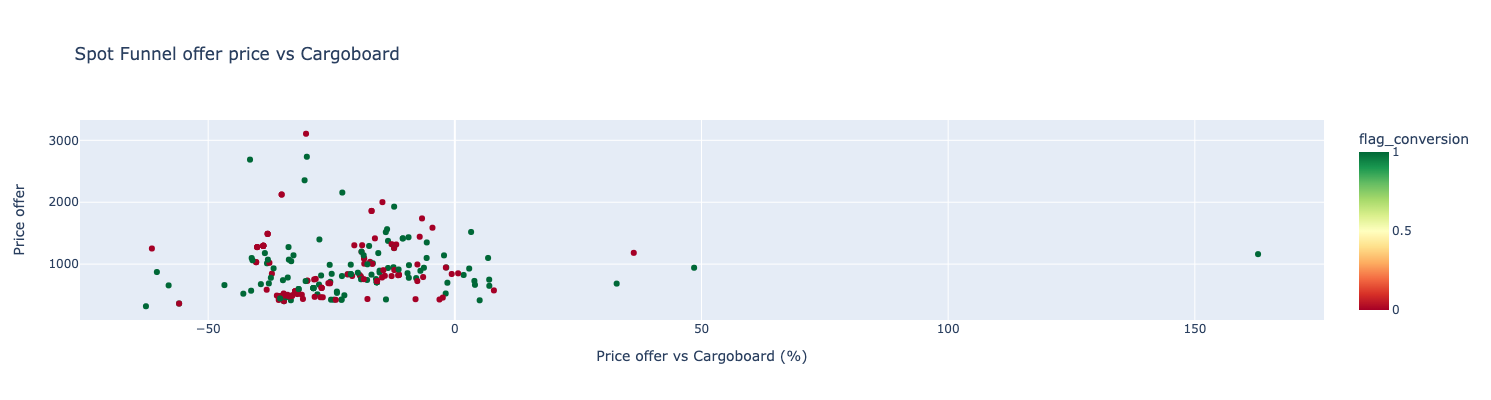

In [100]:
import pandas as pd
import plotly.express as px

# Sample DataFrame (replace with your own data)
scatter_data = final_df[pd.to_numeric(final_df['price_difference'], errors='coerce').notnull()]
#scatter_data=scatter_data[(scatter_data['price_difference'])<50]
# Create a scatter plot for each category

# Define color mapping dictionary

fig = px.scatter(scatter_data, x='price_difference', y='price',
                 color='flag_conversion',
                color_discrete_map={1: 'red', 0: 'green'},
                color_continuous_scale='RdYlGn',
               #  symbol='truck_type', 
                 hover_data=['shipment_id', 'name'],
                 labels={'price_difference': 'Price difference', 'price': 'Price'})


# Add labels and title
fig.update_layout(
    title='Spot Funnel offer price vs Cargoboard',
    xaxis_title='Price offer vs Cargoboard (%)', yaxis_title='Price offer',
    legend=dict(orientation="h", yanchor="bottom", y=.999, x=0.01),
    height=400, width=600,
    showlegend=False,
    margin=dict(t=120) )
#fig.update_traces(showlegend=False)
# Display the plot
fig.show()

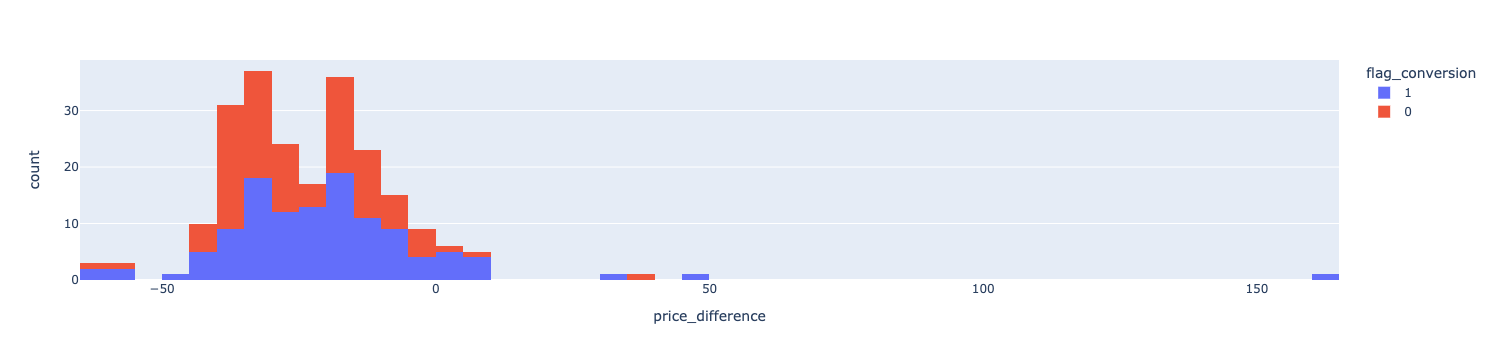

In [431]:
# fig = px.histogram(scatter_data[scatter_data['flag_conversion']==1], x='price_difference', color='flag_conversion')
# fig.show()
# fig = px.histogram(scatter_data[scatter_data['flag_conversion']==0], x='price_difference', color='flag_conversion')
# fig.show()
fig = px.histogram(scatter_data, x='price_difference', color='flag_conversion')
fig.show()